# Финальный Проект Курса "Аналитик Данных"  от Karpov courses


# Вариант 1

# Задание 1

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import pingouin
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [4]:
# считаем наши датафреймы и проведем предобработку 
reg_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-aleksandr-halepov--ed929/shared/problem1-reg_data.csv'
reg_data = pd.read_csv(reg_path, sep=';')

In [5]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.normalize()

In [6]:
reg_data.reg_ts.describe(include='all', datetime_is_numeric=True)

count                          1000000
mean     2019-01-24 00:12:37.209599232
min                1998-11-18 00:00:00
25%                2018-06-03 00:00:00
50%                2019-07-30 00:00:00
75%                2020-04-01 00:00:00
max                2020-09-23 00:00:00
Name: reg_ts, dtype: object

In [7]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
auth_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-aleksandr-halepov--ed929/shared/problem1-auth_data.csv'
auth_data = pd.read_csv(auth_path, sep=';')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.normalize()

In [9]:
auth_data.auth_ts.describe(include='all', datetime_is_numeric=True)

In [11]:
auth_data.shape[0]

9601013

In [12]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Важно отметить, что количество строк в датафреймах отличается.
Посещений значительно больше чем регистраций, следовательно, пользователи используют наш продукт и скорее всего в датафрейме нет критических ошибок.


Так как данных очень много, для ускорение работы тестировать функции будем на пользователях, зарегистрировавшихся в мае 2015 года

In [13]:
reg_2015 = reg_data.query("reg_ts >= '2015-05-01' and reg_ts <= '2015-05-31'")
df = reg_2015.merge(auth_data, on='uid', how='left')

In [19]:
def retention_func(df, days=7):
    
    """
    Функция рассчитывает уровень удержания пользователей за заданный период времени.
    Args:
        df : Датафрейм, содержащий данные о пользователях, с обязательными колонками:
            - 'auth_ts': Время авторизации пользователя (в формате timestamp)
            - 'reg_ts': Время регистрации пользователя (в формате timestamp)
            - 'uid': Уникальный идентификатор пользователя
        days : Количество целых дней для отслеживания retention. 
               Если не передавать количество дней, их значение по умолчанию будет = 7.
               
    Возвращает: сводную таблицу с удержанием пользователей 
        от даты регистрации до количества дней = days (без нулевого дня)
    
    Важно!
    Нулевой день регистрации исключается из итогового анализа для 
        упрощения интерпретации и возможности построения визуализации.
        
    """

    df['auth_ts'] = pd.to_datetime(df['auth_ts']).dt.normalize()
    df['reg_ts'] = pd.to_datetime(df['reg_ts']).dt.normalize()
    df['days_from_reg'] = (df['auth_ts'] - df['reg_ts']).dt.days
    cohort_users = (
        df.groupby('reg_ts', as_index=False)
        .agg({'uid': 'nunique'})
        .rename(columns={'uid': 'total_users'})
    )
    retention_df = (
        df.groupby(['reg_ts', 'days_from_reg'], as_index=False) 
        .agg({'uid': 'nunique'}) 
        .rename(columns={'uid': 'active_users'})
    )
    retention_df = retention_df.merge(cohort_users, on='reg_ts') 
    retention_df['retention'] = round((retention_df['active_users'] / retention_df['total_users']) * 100, 2)
    retention_df = retention_df[retention_df['days_from_reg'] != 0]
    retention_df = retention_df[retention_df['days_from_reg'] <= days]
    pivot_retention = retention_df.pivot(
        index='reg_ts', 
        columns='days_from_reg', 
        values='retention'
    ).fillna(0).reset_index()
    return pivot_retention


In [20]:
pivot_retention = retention_func(df)
pivot_retention.head()

days_from_reg,reg_ts,1,2,3,4,5,6,7
0,2015-05-01,0.00,7.81,7.81,6.25,4.69,9.38,9.38
1,2015-05-02,1.56,1.56,3.12,10.94,7.81,6.25,6.25
2,2015-05-03,0.00,10.77,6.15,4.62,6.15,9.23,3.08
3,2015-05-04,7.81,9.38,3.12,4.69,1.56,9.38,9.38
4,2015-05-05,3.08,6.15,7.69,7.69,12.31,4.62,6.15


# Визуализация RT

Для поиска каких-либо аномалий в наших данных визуализируем таблицу

In [21]:
def retention_heatmap(pivot_df, title="Retention"):
    
    """
    Функция визуализирует удержание пользователей для последующего анализа.
    
    Args:
        pivot_df: сводная таблица полученная функцией "def retention_func(df, days=7)"
        title: необязательный аргумент, 
            по умолчанию выводит название нашей метрики "Retention", 
    
    Возвращает визуалицию удержание с помощью heatmap.
    
    * В случае построения нескольких визуализаций с разными значениями 
        рекомендуется передавать отличительные черты в "title".
    
    """
    
    plt.figure(figsize=(12, 8))
    pivot_df['reg_ts'] = pivot_df['reg_ts'].dt.strftime('%Y-%m-%d')
    ax = sns.heatmap(
        pivot_df.set_index('reg_ts'), 
        annot=True,                      
        fmt=".1f",                       
        cmap="YlGnBu",                   
        linewidths=0.5,              
        cbar_kws={"label": "Retention (%)"}
    )
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Days from Registration", fontsize=12)
    plt.ylabel("Registration Date", fontsize=12)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

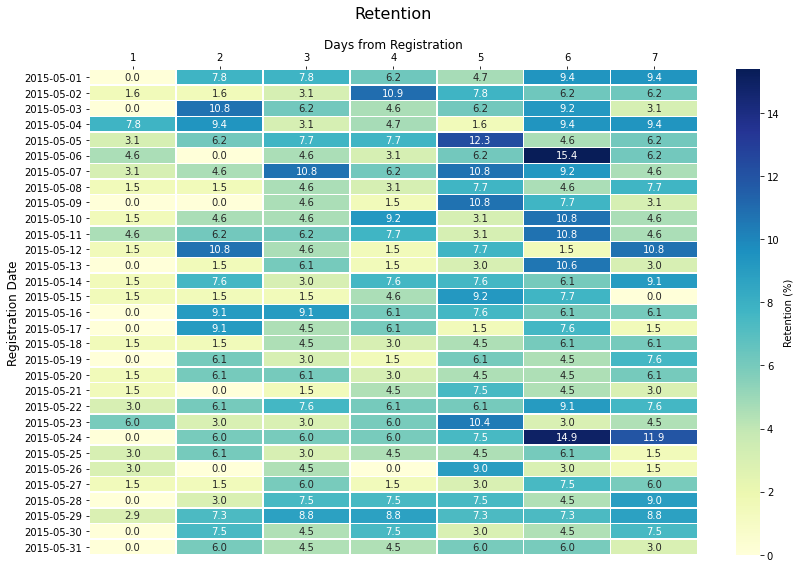

In [22]:
rt_plot = retention_heatmap(pivot_retention)
rt_plot

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [4]:
task2_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-aleksandr-halepov--ed929/shared/problem2.csv'
ab_df = pd.read_csv(task2_path, sep=';')

Проведём предобработку и визуализируем данные

In [25]:
ab_df.shape[0]

404770

In [26]:
ab_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [5]:
ab_df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [30]:
ab_df.user_id.nunique()

404770

Важно отметить, что каждый пользователь в изначальном дф уникален, то есть выборки состоят из полностью разных групп людей.

In [134]:
ab_df.revenue.value_counts()

0       401037
206         18
310         18
265         17
224         17
         ...  
2934         1
2166         1
3447         1
2679         1
3838         1
Name: revenue, Length: 1477, dtype: int64

## Приступим к анализу.

Цель нашего анализа - выявить самую выгодную группу.

Для этого выдвинем гипотезы:
* H0 - Не произошло статистически значимых изменений и контрольная группа обладает более выгодными предложениями.
* H1 - Изменение метрик стат значимо и тестовая группа лучше.

Ключевые метрики нашего анализа: 
* Conversion - по предварительному анализу заметно, что в общем датафрейме очень много не платящих клиентов, поэтому важно отследить конверсию в разбивке по группам.
* ARPU - средняя выручка с пользователя, мы имеем данные по APRU, но разница между группами на первый взгляд несущественная, поэтому нужно проверить стат значимость.
* ARPPU - как уже было сказано ранее, количество платящих клиентов очень маленькое, поэтому ARPU не отражает всей ситуации. Например из-за большой разницы размера групп, отличие ARPU у них может быть очень маленькое, но ARPPU может значительно отличаться.

In [ ]:
# создадим переменные для улучшения читаемости
a_buyers = ab_df.query('(testgroup == "a") & (revenue != 0)').revenue.count()
a_all = ab_df.query('testgroup == "a"').revenue.count()
b_buyers = ab_df.query('(testgroup == "b") & (revenue != 0)').revenue.count()
b_all = ab_df.query('testgroup == "b"').revenue.count()

In [135]:
# конверсия контрольной группы
control_cr = round(a_buyers / a_all * 100, 2) 
control_cr

0.95

In [136]:
# конверсия тестовой группы
test_cr = round(b_buyers / b_all * 100, 2) 
test_cr

0.89

Как и оказалось конверсия у обоих групп маленькая и обладает небольшой разницей.
Поэтому воспользуемся критерием Хи-квадрат для выявления наличия или отсутствия стат значимости. 


Мы можем воспользоваться Хи-квадратов только если соблюдаются условия к его использованию:

    1) Все наблюдения не зависимы

    2) Количество наблюдений > 10

In [137]:
# Проверим сколько покупок было у каждого пользователя
ab_df.groupby('user_id') \
    .agg({"revenue": 'count'}) \
    .rename(columns={'revenue': 'purchases_cnt'}) \
    .value_counts()

purchases_cnt
1                404770
dtype: int64

Таким образом мы точно убедились, что все пользователи делали только одну покупку и данные независимы по этому показателю, и так же мы знаем из условия, что сами наборы предложений в группах отличаются. Помимо этого, требование к кол-ву наблюдений тоже соблюдается.

## Хи-квадрат

In [138]:
# посчитаем кол-во платяших и всех юзеров в группах
с_users = ab_df.query('(testgroup == "a") & (revenue != 0)').revenue.count()
c_all_users = ab_df.query('testgroup == "a"').revenue.count()
t_users = ab_df.query('(testgroup == "b") & (revenue != 0)').revenue.count()
t_all_users = ab_df.query('testgroup == "b"').revenue.count()
print(f"В контрольной группе : {с_users} пользователей совершили покупку из {c_all_users} пользователей.")
print(f"В тестовой группе : {t_users} пользователей совершили покупку из {t_all_users} пользователей.")

В контрольной группе : 1928 пользователей совершили покупку из 202103 пользователей.
В тестовой группе : 1805 пользователей совершили покупку из 202667 пользователей.


In [139]:
cross_control = [1928, 202103]
cross_test = [1805, 202667]
crosstab = np.array([cross_control, cross_test])
print("Таблица сопряженности")
print(crosstab)

Таблица сопряженности
[[  1928 202103]
 [  1805 202667]]


In [140]:
chi2, p_value, dof, expected = chi2_contingency(crosstab)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)


Chi-square statistic: 4.294148751290091
P-value: 0.03824373651044168
Degrees of freedom: 1
Expected frequencies:
[[  1864.48501725 202166.51498275]
 [  1868.51498275 202603.48501725]]


Мы получили p-value < 0.05, следовательно разница в конверсии стат значимая. Так же напомним, что выше она в контрольной группе.

## Анализируем ARPU

Для начала взглянем на распределение выручки по группам.

In [4]:
# отделим группы в разные дф
control = ab_df.query("testgroup =='a'")
test = ab_df.query("testgroup =='b'")

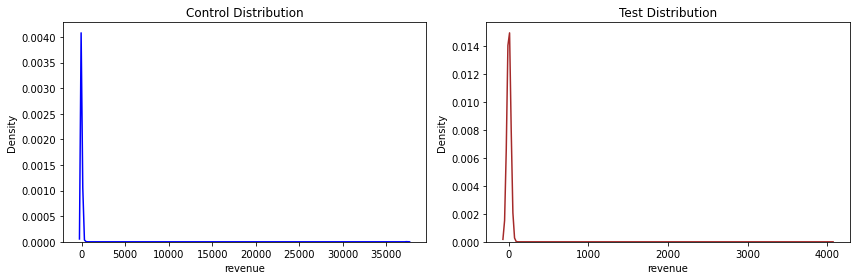

In [142]:
# сравниваем распределения
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(control.revenue, ax=ax[0], color='blue')
ax[0].set_title('Control Distribution')

sns.kdeplot(test.revenue, ax=ax[1], color='brown')
ax[1].set_title('Test Distribution')

plt.tight_layout()  
plt.show()  


In [10]:
# описательная статистика
control.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [11]:
test.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

Распределение групп ненормально. Каким статистическим тестом стоит воспользоваться? Хоть мы и можем в теории воспользоваться T-тестом так как наша выборка большая, из-за большого стандартного отклонения, выбросов в данных, шанс ошибки 1 рода сильно увеличивается. U-тест Манна-Уитни имел бы место быть, но он сложен в интерпретации и не гарантирует уменьшения шанса ошибки 1 рода. Лучшим вариантом будет воспользоваться bootstrap так как он менее чувствителен к выбросом, а значит и обнаружить стат значимость там где её нет, сложнее.






# Bootstrap для ARPU

In [5]:
ci0 = pingouin.compute_bootci(control.revenue, func='mean', n_boot=2000, confidence=0.95)
print(f"Доверительный интервал для среднего: {ci0}")


Доверительный интервал для среднего: [21.55 29.33]


In [6]:
ci1 = pingouin.compute_bootci(test.revenue, func='mean', n_boot=2000, confidence=0.95)
print(f"Доверительный интервал для среднего тестовой группы: {ci1}")


Доверительный интервал для среднего тестовой группы: [25.53 27.98]


Так как доверительные интервалы пересекаются, статистической значимости в разнице нет.

Так же рассмотрим ARPPU.

In [5]:
# собираем группы без нулей
profitable_users = ab_df.query('revenue != 0')
control_pr = profitable_users.query("testgroup =='a'")
test_pr = profitable_users.query("testgroup =='b'")

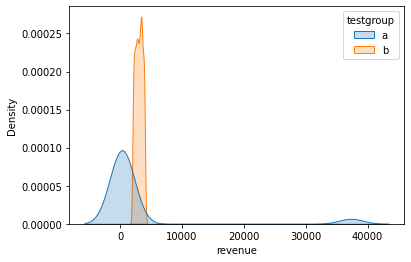

In [144]:
# смотрим распределение групп
sns.kdeplot(data=profitable_users, x='revenue', hue='testgroup', fill=True)
plt.show()


In [6]:
control_pr.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [7]:
test_pr.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Распределение снова ненормально и std ещё более широкое. Тут тоже придётся воспользоваться бутстрепом. 

# Bootstrap для ARPPU

In [9]:
control_ci = pingouin.compute_bootci(control_pr.revenue, func='mean', n_boot=2000, confidence=0.95)
print(f"Доверительный интервал для среднего: {control_ci}")

Доверительный интервал для среднего: [2279.27 3068.53]


In [10]:
test_ci = pingouin.compute_bootci(test_pr.revenue, func='mean', n_boot=2000, confidence=0.95)
print(f"Доверительный интервал для среднего тестовой группы: {test_ci}")


Доверительный интервал для среднего тестовой группы: [2976.61 3028.71]


Интервалы снова пересекаются, стат значимости в разнице ARPPU нет.

Вывод: Мы подтвердили нулевую гипотезу, но не стоит однозначно заявлять, что тестовая группа оказалась провальной. Распределение данных далеко от нормального, возможно сплитование проведено некорректно и дизайн эксперимента нарушен.

**Ответ**: Необходимо проведение повторного эксперимента для корректной оценки успешности тестового продукта.

# Задание 3

# Основные метрики определяющие успех события.

# * Conversion rate
Конверсию мы будем рассматривать в воронке события. Она начинается с прохождения первого уровня ивента и заканчивается полным его прохождением.
Главная цель - увеличивать конверсию в целевое действие в сравнении с событиями прошлых месяцев. Целевым действием считается полное прохождение ивента пользователем.

Так же показатель относительной конверсии влияет на оценку успешности. Относительная конверсия показывает какой процент людей отваливается от каждого следующего действия. В идеале, конверсия между прохождением первого уровня и второго должна быть высокой и превышать конверсию ивентов прошлых месяцев - в противном случае это будет значить, что ивент показался пользователям неинтересным и они отвалились в самом начале воронки. 

 # * Retention
 
Помимо конверсии важно следить за удержанием, так как ограничение события по времени может с разной силой влиять на удержание.
Например, общий быстрый рост удержания среди большинства клиентов в первые дни события может обуславливаться тем, что событие ограничено одной неделей, но уровни открываются не по одному каждый день, а все сразу. Тогда пользователи просто могут пройти все уровни за один день и больше не заходить весь ивент. В зависимости от целей нашей компании можно манипулировать уровнями так, чтобы выйти на желаемый retention. Вариант в которым клиент невынужден заходить в игру каждый день для получения наград скорее всего не будет желаемым, так как у пользователей не так сильно будет развиваться привычка заходить в нашу игру, как могла бы в случае ежедневных уровней.

Также отслеживаем изменение динамики посещения игры клиентами зарегистрировавшимися до события. Здесь можно углубиться и разбить пользователей на когорты по количеству дней в которые они заходили в продукт. Если очень условно делить, то есть клиенты которые пользуются продуктом очень длительное время, например - больше года, и те клиенты, которые играют непродолжительное время, допустим от 2 месяца и до года. Их удержанием может иметь весомое различие, хоть и общая динамика будет иметь сильно выраженный 
тренд.

*Рассмотрим возможный кейс.*

    Игроки с большим стажем показывают очень хорошее удержание, но новые пользователи наоборот перестают играть и заходить в приложение.
    
Почему такое может случиться? Возможно, тематическое событие было ремейком уже случавшегося ранее события (например 1 год назад). Старые пользователи испытывают ностальгию и активно играют в подобие прошлого удачного ивента.
В то же время новые пользователи не имеют такой предвзятости и событие может не понравиться им по множеству причин. Например, дизайн наград сильно отличается от предыдущего события (выглядит менее детализировано).

*Почему это важно отслеживать?*

Размер когорт может довольно сильно отличаться, а может быть примерно равным.
В случае если в одной когорте сильно больше игроков, то их влияние на общий retention будет ключевым и мы можем потерять недовольства меньшей части клиентов. А они хоть и представляют численное меньшинство, но в то же время они могут оказаться более прибыльными клиентами, их LTV (lifetime value) значительно больше чем у другой группы или в среднем они покупают больше внутриигровой валюты (или любого другого внутриигрового контента за деньги), а событие не только будет иметь низкое удержание у них, но и из-за неудовлетворенности событием они могут и вовсе перестать играть. Следовательно, потерять таких клиентов - упустить существенную прибыль


# * ARPU (Average revenue per user)
Динамика среднего чека является важным показателем успешности события. Так как ряд причин должен влиять на динамику затрат клиентов на игру

Идейно, пользователи стремятся заполучить уникальные предметы, возможно не все из них являются гарантийными для получения во время события (обладают низким шансом на выпадение). В таком случае игроки хотят заполучить себе предмет и донатят (покупают внутриигровую валюту и тп.)

Также не все пользователи смогут поучаствовать в событии с первого дня, а раз время на прохождение события ограничено, то будут  люди, желающие пропустить уровни и получить награды.

Полученные бонусы за прохождение ивента могут стимулировать пользователей тратить деньги. Например, заполучив красивую теплицу для сада клиент захочет украсить свой сад большим количеством аксессуаров.


# * Средняя дневная аудитория
Нас интересует динамика средней дневной аудитории за неделю события и ее сравнение с обычными неделями и с неделями прошлых событий, чем больше дневная аудитория - тем успешней наш продукт.

# Сценарий усложения события

*  *В случае если прогресс пользователя будет откатываться на несколько уровней назад, набор наших метрик и их порядок изменится.*

 В нашем кейсе отток клиентов является ключевой метрикой. Под оттоком в этом контексте понимается неполное прохождение ивента игроком на конец события (пользователи начали проходить уровни, но по каким-либо причинам не прошли его). 
Так как увеличение уровня сложности может иметь как позитивный, так и очень негативный эффект на эту метрику, поэтому очень важно отслеживать ее в первую очередь.

Варианты развития событий:
* Пользователи столкнулись с трудностью в прохождении уровней и перестали проходить уровни.


* Пользователи столкнулись с трудностью в прохождении уровней, но метрики CR И RT, и другие, наоборот, показывают отличные результаты.

Почему такое может возникнуть?
Запрос пользователя бывает разным, кого-то пугает сложность, а кто-то воодушевляется перед испытанием.
Главное реализовать сложность таким образом, чтобы она не отталкивала игроков, а заставляла прилагать усилия. Далее дополним этот же анализ другими метриками


# * Количество попыток
С изменениями появляется новая метрика - количество затраченных попыток на прохождение отдельного уровня.
Тут важно выстроить правильную методику расчета, так как по условию в случае невыполнения уровня, игрока откидывает на несколько уровней назад. Будем считать количеством попыток на прохождение уровня - количество уникальных попыток затраченных на прохождение отдельного уровня пользователем **впервые**. В случае если пользователь не смог пройти 8 уровень и его откинуло на 6 уровень, то попытки затраченные на повторное прохождение 6 и 7 уровня считаться не будут.

Это важно, потому что при анализе причин оттока клиентов из воронки на каком-либо этапе вполне можно обнаружить, что большое количество отпавших пользователей имели много попыток прохождения на, например, 8 уровне и просто сдались.
Тут будет уместен разговор о чересчур высокой сложности именно этого уровня, а не всего события. В противном случае можно было бы просто в будущем делать события проще, но это не обязательно бы отражало потребности игроков.

ARPU не стоит включать для оценки успешности, так как усложнение событий - тестовый проект. В нём большую роль играет не прибыль, а изменение динамики таких метрик как conversion, retention так как они показывают заинтересованность пользователей к измененному формату.